# Generative AI Workshop: Tuning Foundational Models
## Carrying out a tuning experiment programatically



In this lab, we will prompt tune a LLama 13B model using the tuning capabilities of `watsonx.ai`. The task is to collect relevant information from text describing neurology-related patents. The collected information must be returned in JSON format, filling-in the following fields: 

- **Label**: A label specific to the patent.
- **Application**: A description of the application of the patent according to its description.
- **Direct_use**: Whether the patent is of direct use ("Direct"), indirect ("Indirect"), a tool ("Tool"), or machine ("Machine"). Multiple categories can be separated by "/".
- **Description**: Description of the claim.
- **Risk description**: Description of potential risks.
- **Risk level**: Classified in Low, Moderate, High, or None.

The dataset that we will use for tuning is extracted from the [HuggingFace Hub](https://huggingface.co/datasets) (a popular repository of open pre-trained models and datasets).

### Prerequisites

- Basic knowledge of Python
- Familiarity with the Jupyter Notebook environment
- An IBM Cloud account
- A project created in Watsonx

In [ ]:
# Install the required libraries
!pip install rich datasets evaluate | tail -n 1
!pip install ibm-watsonx-ai | tail -n 1
!pip install matplotlib | tail -n 1

# Setup Environment

A setup of the environment in watsonx is made, where the API Key to the associated IBM Cloud account and ID of the Project must be indicated.  

In [7]:
import os, json 
import getpass
from ibm_watsonx_ai import APIClient
from rich import print

credentials={
    'url': os.getenv('WML_URL', 'https://us-south.ml.cloud.ibm.com'),
    'apikey': os.getenv('WML_API_KEY') or getpass.getpass('WML API Key: '),
}
project_id = os.getenv('WX_AI_PROJECT_ID') or input("Please enter your project_id (hit enter): ")

client = APIClient(credentials)
client.set.default_project(project_id)

'SUCCESS'

# Data Preparation

Download the data to be used from the HuggingFace Hub and prepare it for the tuning experiment

Dataset source: https://huggingface.co/datasets/RJuro/neuro_patents_sample_finetune

In [3]:
from datasets import load_dataset

dataset_name = "RJuro/neuro_patents_sample_finetune"
dataset = load_dataset(dataset_name)
neuro_patents_df = dataset['train'].to_pandas()
neuro_patents_df.head()

,appln_id,appln_filing_date,docdb_family_id,granted,appln_abstract,appln_abstract_lg,appln_title,applt_coun,invt_coun,cpc,ipc,__index_level_0__,input,completion
0,547033713,2020-09-11,74851316,N,A software utility that collects a suite of ps...,en,"SYSTEM AND METHOD FOR COLLECTING, ANALYZING, A...",79715377_US,"79700984_US,79630309_US","A61B 5/24,G16H 10/20,G16H 40/63,G16H 40/6...","[G16H 10/20, G16H 40/67]",150858,"SYSTEM AND METHOD FOR COLLECTING, ANALYZING, A...","{\n ""label"": ""Cognitive Data Collection Syste..."
1,528677956,2019-09-11,69951164,N,The present disclosure provides a question cor...,en,ANSWER MARKING METHOD FOR MENTAL CALCULATION Q...,81606372_CN,"81616450_CN,81626354_CN,81604721_CN,81653239_CN","G06F 16/245,G06F 40/284,G06K 9/6217,G06N ...","[G06V 10/82, G06V 30/413, G06N 3/04, G06V ...",138740,ANSWER MARKING METHOD FOR MENTAL CALCULATION Q...,"{\n ""label"": ""Answer Marking Method for Menta..."
2,4805858,2003-07-10,29783092,N,We identified a novel protein (Gm1) comprising...,en,"NOVEL G PROTEINS, POLYNUCLEOTIDE ENCODING THE ...",5336856_JP,"10466577_JP,5608910_JP,16758772_JP","A61P 43/00,C07K 14/4722,C07K 16/18,C12P 21...","[C07K 14/47, C07K 14/705]",7900,"NOVEL G PROTEINS, POLYNUCLEOTIDE ENCODING THE ...","{\n ""label"": ""Novel G Protein"",\n ""applicati..."
3,45663896,2002-06-14,23150750,N,This invention pertains to the discovery of a ...,en,A NOVEL SIGNALING PATHWAY FOR THE PRODUCTION O...,"5439802_US,13567886_US,37088040_US","37088040_US,13567886_US","A61K 31/00,A61K 38/164,A61K 38/45,A61K 45/...","[A61K 45/06, A61K 38/16, G01N 33/50, C12Q ...",30889,A NOVEL SIGNALING PATHWAY FOR THE PRODUCTION O...,"{\n ""label"": ""Novel Signaling Pathway for Pai..."
4,509135983,2018-09-27,65631231,Y,Systems and/or devices for efficient and intui...,en,Parallel neural processor for artificial intel...,69930549_CA,69930549_CA,"G06F 9/46,G06K 9/6267,G06K 9/6271,G06K ...","[G06N 3/063, G06N 3/04, G06N 3/08, G06K ...",125903,Parallel neural processor for artificial intel...,"{\n ""label"": ""Parallel neural processor"",\n ..."


The dataset is composed of a series of columns, we are only concerned about the last two: **input** and **completion**. These two columns correspond to the examples of the task to be solved together with the ground-truth output that we would expect to be generated by the model.

To prepare the dataset, first of all the **input** and **completion** columns are selected (completion column is renamed to **output**). Then, the dataset is splitted into a **training set** and a **test set**. The former will be **80%** of the original dataset, and the latter will be the remaining **20%**. The examples taken from the original dataset to form the training set are randomly selected. 

In [4]:
# Rename columns to match the format used for Tuning
neuro_patents_df = neuro_patents_df[['input', 'completion']].rename(columns={'completion': 'output'})
# Split
neuro_patents_df_train = neuro_patents_df.sample(frac=0.8, random_state=42)
neuro_patents_df_test = neuro_patents_df.drop(neuro_patents_df_train.index)
# Save both to JSON
neuro_patents_df_train.to_json('neuro_patents_tuning_train.json', orient='records')
neuro_patents_df_test.to_json('neuro_patents_tuning_test.json', orient='records')
len(neuro_patents_df_train), len(neuro_patents_df_test)

(86, 21)

Inspect a **few samples** from the training set.
- **Input**: green
- **Reference output**: red

In [8]:
neuro_patents_df_train[['input', 'output']].sample(2).apply(
    lambda x: print(f"[green]{x['input']}[red]\n{x['output']}"),
    axis=1
);

Use of BNP during stress testing for the detection and risk stratification of individuals with suspected coronary 
artery disease
A method of early detection and diagnosis of coronary artery disease in a patient comprising a) inducing cardiac 
stress in the patient by either exercise or pharmacological agents; and b) measuring the patient's BNP level before
and after said cardiac stress. Additionally, there is provided a method of risk stratification of severity of 
coronary artery disease.
{
  "label": "Early Detection of Coronary Artery Disease",
  "application": "Detection and risk stratification of individuals with suspected coronary artery disease",
  "direct_use": "Direct",
  "input_description": "BNP level measurement before and after cardiac stress induction",
  "risk_description": "None",
  "risk_level": "None"
}

TRANSCRANIAL CURRENTY STIMULATION SYSTEM AND VIRTUAL REALITY FOR TREATMENT OF PTSD OR FEARS
Described is a system for treating traumatic memories. During a wake stage, a virtual environment is displayed to a
subject. A traumatic episode that may be similar to a traumatic memory of the subject is displayed to the user in 
the virtual environment in a benign setting. A transcranial current stimulation (ICS) controller applies a pattern 
of transcranial direct current stimulation (tDCS) to the subject during the traumatic episode, such that the 
traumatic memory in a benign setting is associated with the pattern of tDCS. During a sleep stage, if slow-wave 
sleep in the subject is def ected via electroencephalogram (EEG) recordings, then in a first time period, the tCS 
controller may a transcranial alternating current stimulation (tACS) to the subject followed by a second time 
period without stimulation, in a third time period, the tCS controller may apply the pattern of tDCS to the 
subject. The sleep stage may be repeated until a desired weakening of the traumatic memory is reached.
{
  "label": "Transcranial Current Stimulation System and Virtual Reality for Treatment of PTSD or Fears",
  "application": "Treatment of traumatic memories and PTSD through a combination of virtual reality and 
transcranial current stimulation",
  "direct_use": "Direct",
  "input_description": "Transcranial direct current stimulation (tDCS), transcranial alternating current 
stimulation (tACS), electroencephalogram (EEG) recordings",
  "risk_description": "Potential risks include discomfort or irritation from the stimulation, and the possibility 
of incomplete or ineffective treatment leading to continued symptoms or relapse.",
  "risk_level": "Moderate"
}

Finally, we will upload the training data to our watsonx.ai project and get a connection to the asset. This is required to run the tuning experiment.

In [9]:
from ibm_watsonx_ai.helpers import DataConnection

# attach the training data to the project
asset_details = client.data_assets.create(name="neuro_patents_tuning_train", file_path="neuro_patents_tuning_train.json")
asset_id = client.data_assets.get_id(asset_details)
data_conn = DataConnection(data_asset_id=asset_id)

Creating data asset...
SUCCESS


# Start and Run the Tuning Experiment

In [13]:
from ibm_watsonx_ai.experiment import TuneExperiment

experiment = TuneExperiment(credentials, project_id=project_id)

### Parameters for Prompt Tuning

Here's a summary of the parameters that can be set in a prompt tuning experiment. The values we chose for this example come after performing various experiments on the same dataset, you'll need to adjust them depending on your use-case. For more information about each parameter, you can [refer to this documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-tuning-parameters.html?context=wx&adoper=178484_1_L1).

| Parameter | Description | Value |
| --- | --- | --- |
| `base_model` | Name of the model to tune | `meta-llama/llama-2-13b-chat` |
| `initialization_method` | Method to initialize the prompt vector. Either `random` or `text`. If `text`, we pass a custom prompt to the experiment | `text` |
| `learning_rate` | Controls the degree to which we are adjust our prompt vector every gradient update | 3e-3 |
| `num_epochs` | Number of epochs (data passes) until the tuning is complete | 30 |
| `batch_size` | Number of samples to process in one step | 8 |
| `accumulate_steps` | Number of steps to accumulate gradients before updating the prompt vector | 16 |
| `max_input_tokens` | Maximum number of tokens in the input prompt. Any input longer than this will be truncated | 512 |
| `max_output_tokens` | Maximum number of tokens to generate. Any output longer than this will be truncated | 256 |

We will first set the prompt that we will use for **initializing the prompt vector** of our tuning experiment. In this case, we've manually crafted this prompt from doing prompt-engineering with the `llama-2-70b-chat` model (the larger model in the llama-2-chat family). By initializing the experiment using this prompt (one we already know can perform reasonably well in our task) we can guide the learning process to generate good outputs early on.

Alternatively, if we didn't have a prompt available, we could set the initialization method to `random`, which would initialize the prompt vector using random values.

In [16]:
# set the prompt used for initializing the model
init_prompt = """
You are a patent assistant with a large experience in specialized data entry in the legal healthcare sector. Your task is to collect information about medical patents and write in structured JSON format relevant information about the patent from its claim. The JSON file must have the following fields: 

- label: a label specific to the patent
- application: A description of the application of the patent according to its description.
- direct_use: Whether the patent is of direct use ("Direct"), indirect ("Indirect"), a tool ("Tool"), or machine ("Machine"). Multiple categories can be separated by "/".
- input description: Description of the claim.
- risk description: Description of potential risks.
- risk level: classified in Low, Moderate, High, or None

Your answer must be in valid JSON format.

Here's an example:

INPUT:
METHOD AND SYSTEM FOR REMOTELY MONITORING THE PSYCHOLOGICAL STATE OF AN APPLICATION USER BASED ON AVERAGE USER 
INTERACTION DATA
An application user is granted access to one or more applications that provide the user with information and 
assistance. Through the one or more applications, the user is provided with interactive content, and data related 
to aspects of the user's interaction with the provided content is collected. The collected interaction data is 
analyzed to remotely identify and monitor changes or anomalies in the psychological state of the user based on 
average user interaction data. Upon identification of changes or anomalies in the user's psychological state, one 
or more actions are taken to assist the user.

{
  "label": "Remote Psychological State Monitoring",
  "application": "Monitoring and assisting users' psychological states based on average interaction data",
  "direct_use": "Tool",
  "input_description": "Average user interaction data collected through one or more applications",
  "risk_description": "Potential risks include misinterpretation of user data leading to incorrect assistance, 
invasion of user privacy, and potential misuse of collected data.",
  "risk_level": "Moderate"
}
""".strip()

We now create a tuning experiment using the parameters and prompt we've set:

In [49]:
# define the tuning experiment
prompt_tuner = experiment.prompt_tuner(
    name="llama2-neuro_patents-tuning",
    description="Tuning a llama-2-13b-chat model on the neuro_patents dataset via notebook",
    task_id=experiment.Tasks.GENERATION, # check experiment.Tasks for all available tasks
    tuning_type=experiment.PromptTuningTypes.PT,# prompt tuning
    base_model="meta-llama/llama-2-13b-chat",
    init_method=experiment.PromptTuningInitMethods.TEXT,
#     init_method=experiment.PromptTuningInitMethods.RANDOM,
    init_text=init_prompt,
    learning_rate=5e-3,
    num_epochs=25,
    batch_size=8,
    accumulate_steps=16,
    max_input_tokens=512,
    max_output_tokens=256,
    group_by_name=True,
)

### Run the Experiment

After the running starts, we'll need to wait for the experiment to finish. You can track its progress via the WatsonX.ai dashboard or by calling the `get_run_status` method on the `prompt_tuner` object from the notebook.

In [52]:
import time

tuning_details = prompt_tuner.run(training_data_references=[data_conn], background_mode=True)
experiment_start = time.time()
while prompt_tuner.get_run_status() not in ['failed', 'canceled', 'completed']:
    print(f"Experiment in {prompt_tuner.get_run_status()} status at {(time.time() - experiment_start)/60:.1f} minutes.")
    tuning_details = prompt_tuner.get_run_details()
    time.sleep(60)
end = time.time() - experiment_start
print(f"Experiment completed after {end/60:.1f} minutes with status: {prompt_tuner.get_run_status()}")
# Experiment completed after 20.9 minutes with status: completed

Experiment in pending status at 0.0 minutes.

Experiment in pending status at 1.1 minutes.

Experiment in pending status at 2.1 minutes.

Experiment in running status at 3.2 minutes.

Experiment in running status at 4.3 minutes.

Experiment in running status at 5.3 minutes.

Experiment in running status at 6.4 minutes.

Experiment in running status at 7.5 minutes.

Experiment in running status at 8.5 minutes.

Experiment in running status at 9.6 minutes.

Experiment in running status at 10.6 minutes.

Experiment in running status at 11.7 minutes.

Experiment in running status at 12.8 minutes.

Experiment in running status at 13.8 minutes.

Experiment in running status at 14.9 minutes.

Experiment in running status at 15.9 minutes.

Experiment in running status at 17.0 minutes.

Experiment in running status at 18.1 minutes.

Experiment in running status at 19.1 minutes.

Experiment completed after 20.2 minutes with status: completed

## Check Results

Once the experiment has finished its execution, we can get an analysis of the training process

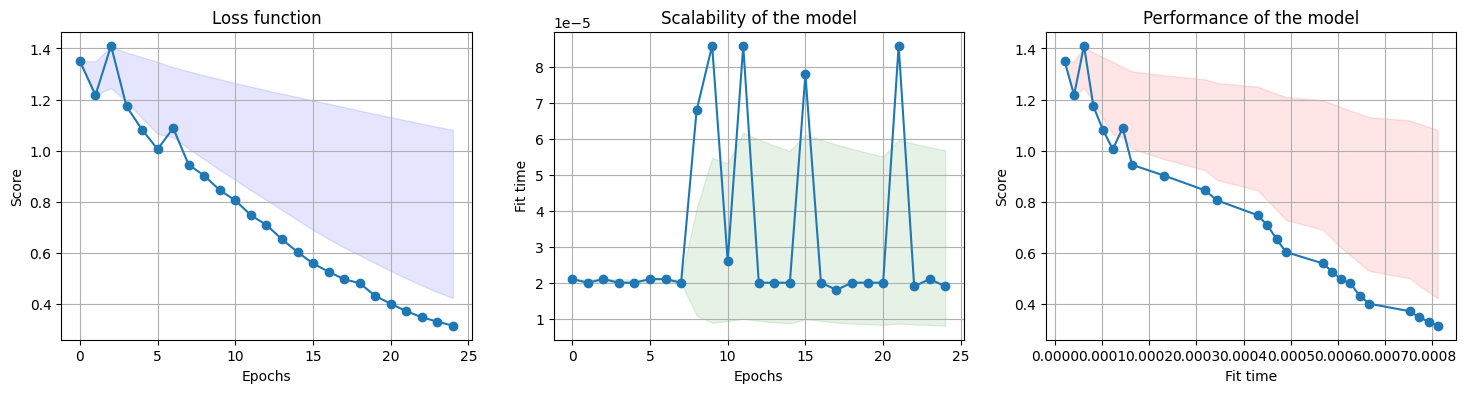

In [53]:
import matplotlib.pyplot as plt
prompt_tuner.plot_learning_curve()
fig = plt.gcf()

Focusing on the loss function, we can observe that the loss curve drops and decreases steadily, but **never levels off**. In this case, another experiment could be launched by increasing the number of epochs to give the model more time to learn. For this experiment, the result is sufficient.

# Model Deployment

The resulting model is **deployed** in the project of watsonx. This is required to subsequently run the test set inference on the tuned model.

In [ ]:
model_id = None
tuning_details = prompt_tuner.get_run_details()
if 'model_id' in tuning_details.get('entity', {}):
    model_id = tuning_details['entity']['model_id']
model_id

In [ ]:
from datetime import datetime
meta_props = {
    # Name of the deployemnt
    client.deployments.ConfigurationMetaNames.NAME: "Prompt Tuning Deployment - llama-2-13b on neuro_patents dataset (random init)",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    # name of the serving instance
    client.deployments.ConfigurationMetaNames.SERVING_NAME : f"llama2_neuropatents_pt_{datetime.utcnow().strftime('%Y%m%d')}_rand",
}
deployment_details = client.deployments.create(model_id, meta_props)

# Inference

We proceed to perform the **test set inference** for the tuned model. First, we define the model generation parameters and the model inference.

In [16]:
from ibm_watsonx_ai.foundation_models import Model, ModelInference
import pandas as pd

model_params = {
    'decoding_method': 'greedy',
    'max_new_tokens': 256,
    'stop_sequences': ["}"],
}
deployment_id='dd3d62e2-1f67-4aad-b893-84ba5cd1cbee'
tuned_model = ModelInference(
    deployment_id=deployment_id,
    params=model_params,
    credentials=credentials,
    project_id=project_id,
    space_id='efaa99f6-285e-4cbc-a47f-22e528d6e65e', # in case you have multiple spaces
)

Let's run inference on **one observation** of the test data.

- **Test data sample**: green
- **Reference output**: red
- **Generated output**: blue

In [17]:
sample = neuro_patents_df_test.sample(1)
input_text = sample['input'].values[0]
true_output = sample['output'].values[0] 
response = tuned_model.generate(input_text)['results'][0]
print(response['input_token_count'], 'input tokens and', response['generated_token_count'], ' tokens generated')
print(f"[green]{input_text}[red]\nGround Truth:\n{true_output}\n[blue]Generated:\n{response['generated_text']}")

197 input tokens and 110  tokens generated


Pronunciation activity detector
The utility model relates to a pronunciation activity detector, include: receive the first signal's first detector,
the receipt is different from the second detector of the first signal's second signal, pronunciation activity 
detector parts, pronunciation activity detector parts are couple to first detector with the second detector, the 
2nd pronunciation activity detector parts, the 2nd pronunciation activity detector parts are couple to the second 
detector, the contact detection ware, the contact detection ware is couple to pronunciation activity detector parts
with the 2nd pronunciation activity detector parts, and selector, the selector is couple to pronunciation activity 
detector parts with the 2nd pronunciation activity detector parts. The utility model discloses handle received 
speech signal in order to maintain and to strengthen sound articulation.
Ground Truth:
{
  "label": "Pronunciation Activity Detector",
  "application": "Detects pronunciation activity in speech signals to maintain and strengthen sound articulation.",
  "direct_use": "Tool",
  "input_description": "First signal's first detector, first signal's second signal, second detector, pronunciation
activity detector parts, 2nd pronunciation activity detector parts, contact detection ware, and selector.",
  "risk_description": "None obvious",
  "risk_level": "None"
}
Generated:
 {
  "label": "Pronunciation Activity Detector",
  "application": "Detects and strengthens sound articulation in speech signals",
  "direct_use": "Tool",
  "input_description": "First signal, second signal, pronunciation activity detector parts, 2nd pronunciation 
activity detector parts, contact detection ware, selector",
  "risk_description": "None",
  "risk_level": "None"
}

Now, we perform the iference of the entire test data.

In [20]:
from tqdm.notebook import tqdm
import time

test_results = {}
test_results['llama-2-13b-tuned'] = []
for i, row in tqdm(neuro_patents_df_test.iterrows(), total=len(neuro_patents_df_test)):
    input_text = row['input']
    true_output = row['output']
    tstart = time.time()
    response = tuned_model.generate(input_text)['results'][0]
    time_taken = time.time() - tstart
    test_results['llama-2-13b-tuned'].append({
        'input': input_text,
        'true_output': true_output,
        'generated_output': response['generated_text'],
        'input_token_count': response['input_token_count'],
        'generated_token_count': response['generated_token_count'],
        'response_time_seconds': round(time_taken, 4),
    })
print("Done!" )

  0%|          | 0/21 [00:00<?, ?it/s]

Done!


# Evaluation and Comparison

Let's compare the inference of the **LLaMa-2-13b-chat tuned model** against the base **LLaMa-2-13b-chat** and **LLaMa-2-70b-chat** models with the same **two-shot prompt**.

We first write the two-shot prompt (instructions + examples) to generate completions with the non-tuned models.

In [21]:
prompt = """
You are a patent assistant with significant experience in data entry for the legal healthcare sector. Your task is to collect information about medical patents and write in structured JSON format relevant information about the patent from its claim. 

Your output should be a valid JSON object with the following fields: 

- label: a label specific to the patent
- application: A description of the application of the patent according to its description.
- direct_use: Whether the patent is of direct use ("Direct"), indirect ("Indirect"), a tool ("Tool"), or machine ("Machine"). Multiple categories can be separated by "/".
- input description: Description of the claim.
- risk description: Description of potential risks.
- risk level: classified in Low, Moderate, High, or None

INPUT:
Method for measuring and analyzing bioluminescence and device for measuring and analyzing bioluminescence
A method for measuring and analyzing bioluminescence, including the steps of receiving in real-time a luminescence measurement result group from a creature sample group, 
displaying and maintaining in real-time the luminescence measurement result group,  receiving in real-time another luminescence measurement result group from the creature sample group, 
and displaying and maintaining in real-time the another luminescence measurement result group, instead of the luminescence measurement result group.

OUTPUT:
{{
  "label": "Method for measuring and analyzing bioluminescence",
  "application": "Real-time monitoring and analysis of bioluminescence in creature sample groups",
  "direct_use": "Tool",
  "input_description": "Creature sample groups",
  "risk_description": "None",
  "risk_level": "None"
}}

INPUT:
PPAR-GAMMA AGONISTS FOR IMPROVEMENT OF COGNITIVE FUNCTION IN APOE4 NEGATIVE PATIENTS
A method for improving cognitive function in a subject suffering from or susceptible to MCI, Alzheimer's disease or other dementias, which subject is not homozygous for the APOE4 allele, comprising the steps of: 
(i) screening the subject to determine that the subject is not homozygous for the APOE4 allele; and then (ii) administering a safe and effective amount of a PPAR-gamma agonist to said subject.

OUTPUT:
{{
  "label": "PPAR-Gamma Agonists for Cognitive Function",
  "application": "Improvement of cognitive function in APOE4 negative patients with MCI, Alzheimer's disease, or other dementias",
  "direct_use": "Direct",
  "input_description": "PPAR-gamma agonist",
  "risk_description": "Potential side effects include weight gain, fluid retention, and increased risk of heart failure. These risks are considered moderate.",
  "risk_level": "Moderate"
}}

INPUT:
{input}

OUTPUT:
""".strip()

Now, we will execute the inference for the two non-tuned models. The results are saved in the same dictionary where the tuned model results were saved in the previous inference process.

In [24]:
models = ['meta-llama/llama-2-13b-chat', 'meta-llama/llama-2-70b-chat']
for m in models:
    test_results[m] = []
    model = Model(
        m, params=model_params, credentials=credentials, project_id=project_id
    )
    for i, row in (neuro_patents_df_test.iterrows()):
        input_text = prompt.format(input=row['input'])
        true_output = row['output']
        tstart = time.time()
        response = model.generate(input_text)['results'][0]
        time_taken = time.time() - tstart
        test_results[m].append({
            'input': input_text,
            'true_output': true_output,
            'generated_output': response['generated_text'],
            'input_token_count': response['input_token_count'],
            'generated_token_count': response['generated_token_count'],
            'response_time_seconds': round(time_taken, 4),
        })

Collect all results into one dataframe.

In [25]:
test_results_df = pd.concat([pd.DataFrame(v).assign(model=k.split('/')[-1]) for k, v in test_results.items()]).set_index(['model', 'input'])

### Text similarity scores between the generated completions and the reference completions

In [27]:
!pip install nltk rouge-score | tail -n 1

Compare the generated outputs with the reference outputs using BLEU and ROUGE scores.

- **BLEU (Bilingual Evaluation Understudy)** is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine’s output and that of a human: “the closer a machine translation is to a professional human translation, the better it is” – this is the central idea behind BLEU. Although developed for translation, it can be used to evaluate text generated for different natural language processing tasks, such as paraphrasing and text summarization. For more information about BLEU, click on [this link](https://huggingface.co/spaces/evaluate-metric/bleu).

- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation. For this case, we use Rouge1 (unigram based scoring). For more information about ROGUE, click on [this link](https://huggingface.co/spaces/evaluate-metric/rouge).

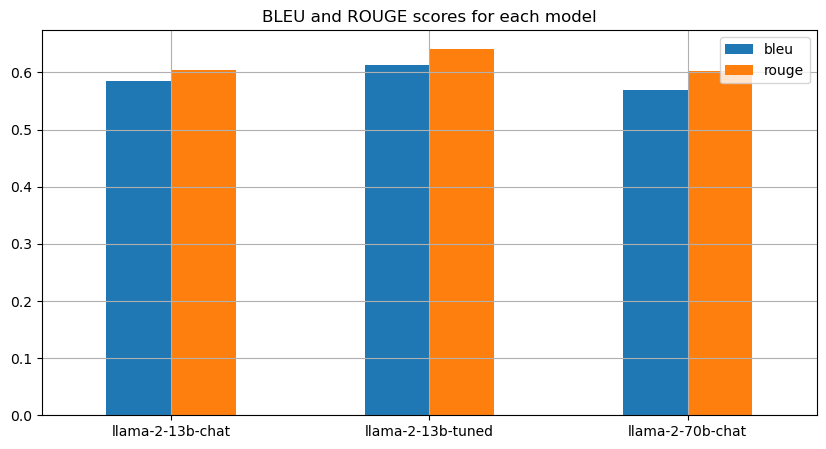

In [28]:
import evaluate

scorers = [evaluate.load('bleu'), evaluate.load('rouge')]

scores = {}
for m, group in test_results_df.groupby('model'):
    predictions = group['generated_output'].fillna('')
    references = group[f'true_output'].fillna('')
    scores[m] = {}
    for scorer in scorers:
        if scorer.name == 'bleu':
            scores[m][scorer.name] = scorer.compute(predictions=predictions, references=references)['bleu']
        elif scorer.name == 'rouge':
            scores[m][scorer.name] = scorer.compute(predictions=predictions, references=references)['rouge1']
pd.DataFrame(scores).T.plot(kind='bar', title='BLEU and ROUGE scores for each model', figsize=(10, 5), grid=True, rot=0);

Although the difference is not great, the tuned model has the maximum score for BLEU and ROUGE metrics.

### Classification Accuracy of `direct_use` and `risk_level`

`direct_use` and `risk_level` are categorical features that had to be classified by the model. We can compare the labels classified by each model with the true labels.

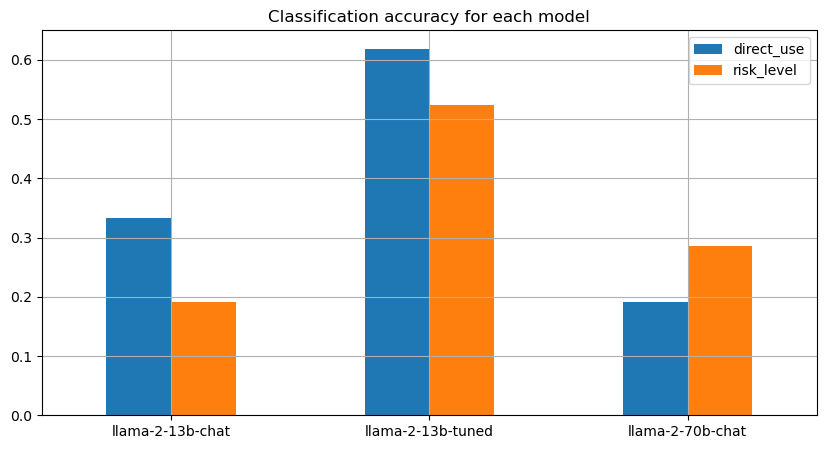

In [30]:
import re

def parse_json(x):
    try:
        return json.loads(re.findall(r"({.*})", x.strip(), re.DOTALL)[0])
    except Exception as e:
        return None

def expand_on_dict_column(df, column):
    df_col = df[column].apply(pd.Series)
    df = df.drop(columns=[column])
    return pd.concat([df, df_col], axis=1)

# parse the generated outputs and extract the JSON fields
test_results_parsed = test_results_df.assign(
    generated_output= test_results_df['generated_output'].apply(parse_json),
    true_output= test_results_df['true_output'].apply(parse_json)
)
generated_df = expand_on_dict_column(test_results_parsed, 'generated_output')
true_df = expand_on_dict_column(test_results_parsed, 'true_output')
field_results_df = generated_df.join(true_df, lsuffix='_predicted', rsuffix='_true')

# evaluate classification results of 'direct_use' and 'risk_level' fields for each experiment
classification_results = {}
for m, group in field_results_df.groupby('model'):
    classification_results[m] = {}
    for field in ['direct_use', 'risk_level']:
        classification_results[m][field] = (group[field+'_predicted'] == group[field+'_true']).mean()
        
pd.DataFrame(classification_results).T.plot(kind='bar', title='Classification accuracy for each model', figsize=(10, 5), grid=True, rot=0);

Here the tuned model did it much better. Note how it even surpassed the LLaMa 70b scores by a significant margin.

### Tokens consumed:

The number of input/output tokens consumed gives us an idea of how efficient the model is and how much it'll cost to run it in production. Larger models tend to have a higher cost per token associated with them.

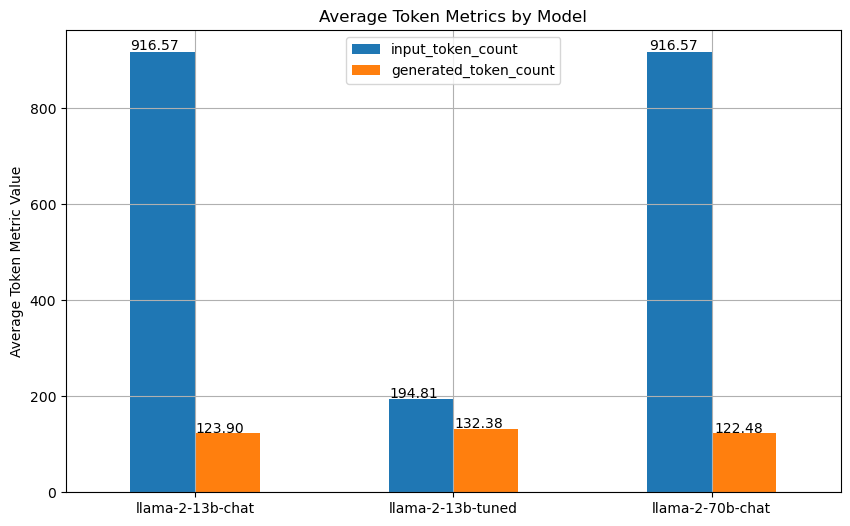

In [31]:
# number of input/output tokens per model
ax = test_results_df.groupby('model').mean().filter(regex='.*_token_.*').plot(
    kind='bar',
    figsize=(10, 6),
    title='Average Token Metrics by Model',
    ylabel='Average Token Metric Value',
    xlabel='',
    grid=True,
    rot=0
)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.005))
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

Even thought the generated token counts are similar, the tuned model only sends the input in a zero-shot fashion without the need of a text Instruction, while the other two require a two-shot prompt, which makes the number of input tokens consumed by them much higher (and hence the inference more expensive).

### Response time:

Some tasks require a quick response time, so it's important to know how long it takes each model to generate completions.

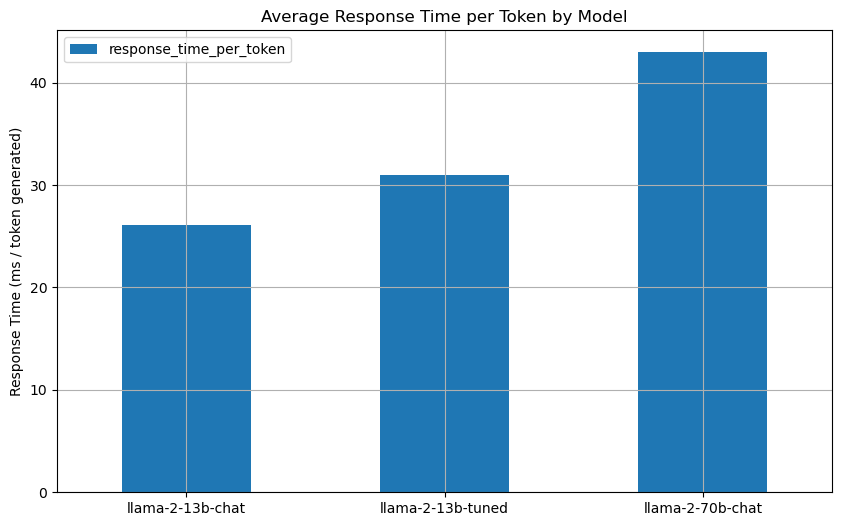

In [33]:
ax = test_results_df.groupby('model').mean().assign(
    response_time_per_token=lambda x: (x['response_time_seconds'] / x['generated_token_count'])*1000
)[['response_time_per_token']].plot(
    kind='bar',
    figsize=(10, 6),
    title='Average Response Time per Token by Model',
    ylabel='Response Time (ms / token generated)',
    xlabel='',
    grid=True,
    rot=0
)